In [1]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

In [2]:
# reading in existing dG dataset
dft_data = pd.read_csv('../Data/Predictive_Modeling_Inputs/dft_descriptors_full.csv')
dG_data = dft_data[['Cofactor', 'dG_C5']]

In [3]:
# using assigned names
cofactor_name = dG_data['Cofactor'].to_list()
cofactor_name

names = []
for i in cofactor_name:
    name = i.split('_')[0]
    names.append(name)

dG_data = dG_data.drop(columns=['Cofactor'],axis=1)
dG_data['Cofactor'] = names

In [4]:
# isolating BMCs selected for TS calculations
bmcs_to_sample = ['A1a', 'A5a', 'A5b', 'A3b', 'B2b', 'B3a', 'B6b', 'D5b', 'D3a', 'D6a', 
                  'C1b', 'C3b', 'C6a', 'E1a', 'E1b', 'E2a', 'E2b', 'E3a', 'E3b', 'J1a', 
                  'J1b', 'J5a', 'J5b', 'J4a', 'F1a', 'F3b', 'F6a', 'G3b', 'G4a', 'K1b', 
                  'K3a', 'K3b', 'K4b', 'K6b']

selected_dG_data = dG_data.loc[dG_data['Cofactor'].isin(bmcs_to_sample)]

In [5]:
# finding barrier data
kinetic_barrier = pd.read_csv('../Data/Kinetic_Thermodynamic_Correlation/kinetic_thermo_results_library_subset.csv')
barriers = kinetic_barrier[['Cofactor Name','barrier']]
barriers['Cofactor'] = bmcs_to_sample
barriers = barriers.drop(columns=['Cofactor Name'],axis=1)

/var/folders/nh/3ms2hwln7kv2bfrhtl8myjr00000gn/T/ipykernel_25240/3188731198.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barriers['Cofactor'] = bmcs_to_sample


In [6]:
# merging large datasets
large_set_corr_data = pd.merge(selected_dG_data,barriers,on='Cofactor')

In [7]:
selected_r3H = []
selected_r3Me = []

for idx,row in large_set_corr_data.iterrows():
    cofactor_id = row['Cofactor']
    if 'a' in cofactor_id:
        selected_r3H.append(cofactor_id)
    elif 'b' in cofactor_id:
        selected_r3Me.append(cofactor_id)

r3H_correlation_data = large_set_corr_data.loc[large_set_corr_data['Cofactor'].isin(selected_r3H)]
r3Me_correlation_data = large_set_corr_data.loc[large_set_corr_data['Cofactor'].isin(selected_r3Me)]

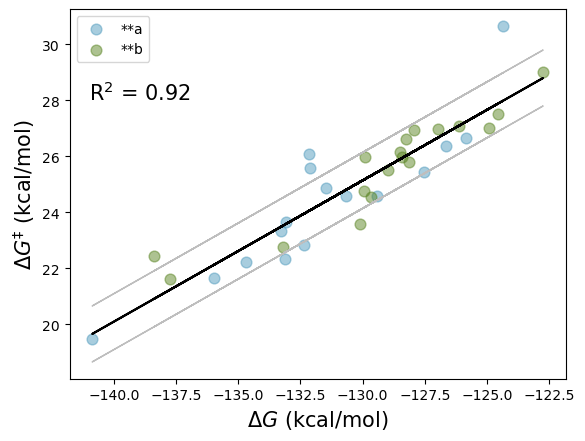

In [19]:
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(large_set_corr_data['dG_C5'],
                                                                     large_set_corr_data['barrier'])
abline_values = [slope * i + intercept for i in large_set_corr_data['dG_C5']]
abline_add = []
abline_sub = []
for i in abline_values:
    abline_add.append(i + 1)
    abline_sub.append(i - 1)

plt.plot(large_set_corr_data['dG_C5'],abline_values,color='#000000')
plt.plot(large_set_corr_data['dG_C5'],abline_add,color='#bebebe',linewidth=1)
plt.plot(large_set_corr_data['dG_C5'],abline_sub,color='#bebebe',linewidth=1)
plt.scatter(r3H_correlation_data['dG_C5'],r3H_correlation_data['barrier'],
            color='#529cbe',s=60, label='**a',alpha=0.50,edgecolors='#529cbe')
plt.scatter(r3Me_correlation_data['dG_C5'],r3Me_correlation_data['barrier'],
            color='#5c8625',s=60, label='**b',alpha=0.50,edgecolors='#5c8625')
plt.ylabel(r'$\Delta ' + u'G^{{\u2021}}$ (kcal/mol)',fontsize=15)
plt.xlabel(r'$\Delta G$ (kcal/mol)',fontsize=15)
plt.annotate(f'R$^2$ = {"{:.2f}".format(r_value)}'.format(r2_score(large_set_corr_data['dG_C5'], 
                                                                   large_set_corr_data['barrier'])), 
                                                                   (-141, 28),fontsize=15)
plt.legend()

# plt.savefig('corr_plot_coloredr3_1kcal.svg',dpi=400)

In [9]:
# adding novel structures
# finding barrier data
new_kinetic_barrier = pd.read_csv('../Data/Kinetic_Thermodynamic_Correlation/kinetic_thermo_results_designed_structures.csv')
new_barriers = new_kinetic_barrier[['Cofactor Name','barrier']]

new_dG_dict = {'Cofactor Name' : ['NsubI','NsubII','NsubIII','NsubIV','NsubV','NsubVI',
                             'NsubS','C3subI','C3subII','C3subIII','C3subIV',
                             'C5subI','C5subII'],
               'dG_C5' : [-122.0,-120.8,-121.3,-117.3,-122.4,-121.7,-117.2,
                          -124.8,-125.2,-127.5,-120.0,-122.0,-117.1]}
new_dGs = pd.DataFrame.from_dict(new_dG_dict)

new_corr = pd.merge(new_barriers,new_dGs,on='Cofactor Name')

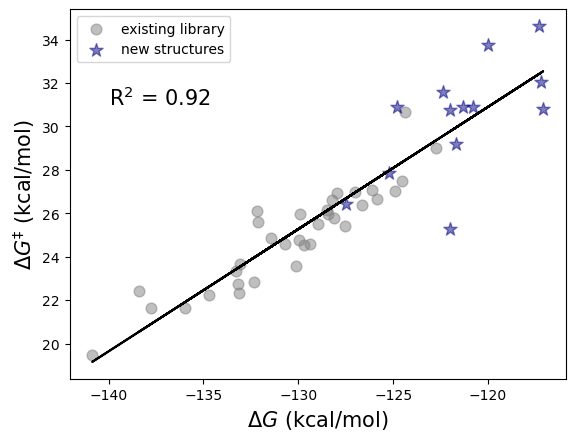

In [10]:
all_corr = pd.concat([large_set_corr_data,new_corr])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(all_corr['dG_C5'],
                                                                     all_corr['barrier'])
abline_values = [slope * i + intercept for i in all_corr['dG_C5']]

plt.plot(all_corr['dG_C5'],abline_values,color='#000000')
plt.scatter(large_set_corr_data['dG_C5'],large_set_corr_data['barrier'],
            color='#808080',s=60, label='existing library',alpha=0.50)
plt.scatter(new_corr['dG_C5'],new_corr['barrier'],
            color='#000080',s=100, label='new structures',alpha=0.50,marker='*')
plt.ylabel(r'$\Delta ' + u'G^{{\u2021}}$ (kcal/mol)',fontsize=15)
plt.xlabel(r'$\Delta G$ (kcal/mol)',fontsize=15)
plt.annotate(f'R$^2$ = {"{:.2f}".format(r_value)}'.format(r2_score(large_set_corr_data['dG_C5'], 
                                                                   large_set_corr_data['barrier'])), 
                                                                   (-140, 31),fontsize=15)
plt.legend()

# plt.savefig('corr_plot_new_structures.svg',dpi=400)

Text(0.5, 0, '$\\Delta G$ (kcal/mol)')

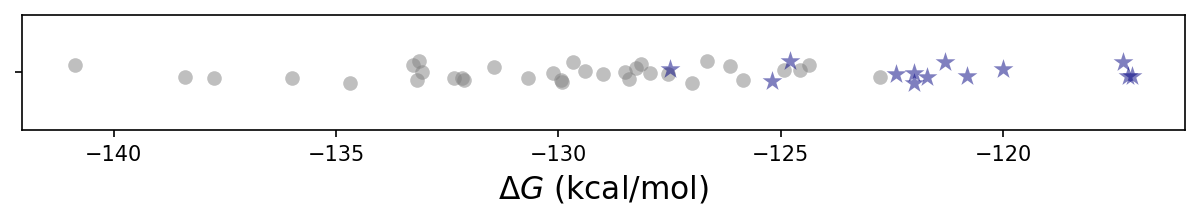

In [11]:
# showing distribution of stabilities for the full library including our new designed structures
import seaborn as sns 

# strip plot colored by current library or new
f = plt.figure(figsize=(10,1),dpi=150)
sns.stripplot(x=large_set_corr_data['dG_C5'], color='#808080', size=7, alpha=0.5, 
              edgecolors='#808080',marker='o')
sns.stripplot(x=new_corr['dG_C5'], color='#000080',size=10, alpha=0.5,
              edgecolors='#000080', marker='*')
plt.xlabel(r'$\Delta G$ (kcal/mol)',fontsize=15)

# plt.savefig('dG_comparison_library_vs_new.svg',dpi=400)

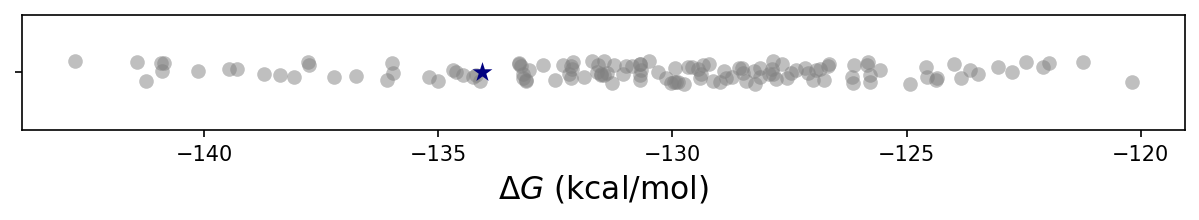

In [36]:
# stripplot showing stability of library BMCs vs NMNH 1-
nmnh_stability = [-134.065375] #kcal/mol

# strip plot colored by current library or new
f = plt.figure(figsize=(10,1),dpi=150)
sns.stripplot(x=dft_data['dG_C5'], color='#808080', size=7, alpha=0.5, 
              edgecolors='#808080',marker='o')
# sns.stripplot(x=new_corr['dG_C5'], color='#808080',size=7, alpha=0.5,
#               edgecolors='#000080', marker='o')
sns.stripplot(x=nmnh_stability, color='#000080', size=10, alpha=1,
              edgecolor='#000080', marker='*')
plt.xlabel(r'$\Delta G$ (kcal/mol)',fontsize=15)

plt.savefig('dG_comparison_library_vs_nmnh1-.svg',dpi=400)